<center><h3>Predicting tweet sentiments</h3></center>

You work in an event management company. On Mother's Day, your company has organized an event where they want to cast positive Mother's Day related tweets in a presentation. Data engineers have already collected the data related to Mother's Day that must be categorized into positive, negative, and neutral tweets.

You are appointed as a Machine Learning Engineer for this project. Your task is to build a model that helps the company classify these sentiments of the tweets into positive, negative, and neutral.

### Data description

This data set consists of six columns:

Column Name	Description
- id	ID of tweet
- original_text	Text of tweet
- lang	Language of tweet
- retweet_count	Number of times retweeted
- original_author	Twitter handle of Author
- sentiment_class	Sentiment of Tweet (Target)

In [28]:
# importing packages
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn packages
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn import decomposition, ensemble
import pandas, xgboost, numpy, string #textblob,
from sklearn.metrics import classification_report

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation
# import unidecode

In [32]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
# vaderSentiment
# good - 0.34
# bad - -.45
# better - 0.56

## Exploration
Let’s get a feel for our data. Here are the first 5 rows of the training data:

In [33]:
train.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


In [34]:
test.head()

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg


In [35]:
train.sentiment_class.value_counts()

 0    1701
-1     769
 1     765
Name: sentiment_class, dtype: int64

In [36]:
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\va4nfjfq5b", " ")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [37]:
train['original_text']=train['original_text'].apply(tweet_cleaner)

In [38]:
train['original_text'][0]

'happy mothersday to all you amazing mothers out there i know it s hard not being able to see your mothers today but it s on all of us to do what we can to protect the most vulnerable members of our society beatcoronavirus pic twitter com va nfjfq b'

In [39]:
test['original_text']=test['original_text'].apply(tweet_cleaner)

In [40]:
test['original_text'][0]

'yeah i once cooked potatoes when i was years old and by that i mean i threw a bag of spuds into the toilet happy mothers day i made breakfast that time i thought i was cool by drawing the naked lady dachshund on the overhead projector in psychology class'

### Stop word

In [41]:
# defining stopwords: using the one that comes with nltk + appending it with words seen from the above evaluation
stop_words = stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'nfjfq ', 'com', '%', 'twitter ']

## Stemming and Lemmatization

We have an immense number of word forms as you can see from our various counts in the `FreqDist` above - it is helpful for many applications to normalize these word forms (especially applications like search) into some canonical word for further exploration. In English (and many other languages) - morphological context indicate gender, tense, quantity, etc. but these 

#### .2 POS tagging and Lemma tokenization
In the description text a word might appear in different forms while actually representing the same word, like good and best. To reduce noise we try to find the basic form (lemma) of each word in the text. We will rely on the nltk package to achieve this, but first we have to type tag each word, wether they are nouns, verbs, adjectives or adverbs. For that we built up some helper functions.

In [42]:
# # list of word types (nouns and adjectives) to leave in the text
# defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# # functions to determine the type of a word
# def is_noun(tag):
#     return tag in ['NN', 'NNS', 'NNP', 'NNPS']


# def is_verb(tag):
#     return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


# def is_adverb(tag):
#     return tag in ['RB', 'RBR', 'RBS']


# def is_adjective(tag):
#     return tag in ['JJ', 'JJR', 'JJS']

# # transform tag forms
# def penn_to_wn(tag):
#     if is_adjective(tag):
#         return nltk.stem.wordnet.wordnet.ADJ
#     elif is_noun(tag):
#         return nltk.stem.wordnet.wordnet.NOUN
#     elif is_adverb(tag):
#         return nltk.stem.wordnet.wordnet.ADV
#     elif is_verb(tag):
#         return nltk.stem.wordnet.wordnet.VERB
#     return nltk.stem.wordnet.wordnet.NOUN
    
# # lemmatizer + tokenizer (+ stemming) class
# class LemmaTokenizer(object):
#     def __init__(self):
#         self.wnl = WordNetLemmatizer()
#         # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
#         self.stemmer = nltk.stem.SnowballStemmer('english') 
#     def __call__(self, doc):
#         # pattern for numbers | words of length=2 | punctuations | words of length=1
#         pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
#         # tokenize document
#         doc_tok = word_tokenize(doc)
#         #filter out patterns from words
#         doc_tok = [x for x in doc_tok if x not in stop_words1]
#         doc_tok = [pattern.sub('', x) for x in doc_tok]
#         # get rid of anything with length=1
#         doc_tok = [x for x in doc_tok if len(x) > 1]
#         # position tagging
#         doc_tagged = nltk.pos_tag(doc_tok)
#         # selecting nouns and adjectives
#         doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
#         # preparing lemmatization
#         doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
#         # lemmatization
#         doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
#         # uncomment if you want stemming as well
#         #doc = [self.stemmer.stem(x) for x in doc]
#         return doc

In [43]:
#  create a dataframe using texts and lables

texts=train['original_text']
labels=train['sentiment_class']
#  split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = train_test_split(texts, labels,test_size=0.3, random_state = 42)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

### Text vectorizer
To transform the text based description column into a number based object, we use term frequency-inverse document frequency (tf-idf) vectorization. First it counts the occurance of a word in one sample and than down-weighs it with the occurance of the same word over all the samples. It repeats this process for each word and outputs a vector of numbers, where each number represents a word. The actual vectorizer performes some firther normalization too. We have decided to analyse the text word by word (1-grams), but you could choose 2-grams or n-grams, meaning selecting the first n words to represent the first element of the vector. Then each consequent element would be constructed by shifting the n-range by one. The vectorizer accepts a tokenizer as an input, that is why we have defined one previously. The vectorizer gives a lot of opportunities for different setups and tests. If you want to see a smaller experiment with it,

In [44]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(texts)

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)


# transform the validation data using count vectorizer object
testx=test['original_text']
xtest_count =  count_vect.transform(testx)

In [45]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(texts)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(texts)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(texts)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x)

zvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(test['original_text'])

C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:501: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [46]:
def train_models(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
#     add_element(d,(metrics.accuracy_score(predictions, valid_y)),accuracy_score)
#     add_element(d,,f1_score)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
        
    return (f1_score(predictions, valid_y,average='weighted') * 100)

### Naive Baye's

In [17]:
classifier_nb=MultinomialNB()
classifier_nb.fit( xtrain_tfidf_ngram, train_y)
predictions = classifier_nb.predict(xvalid_tfidf_ngram)
acc=metrics.accuracy_score(predictions, valid_y)
score=f1_score(predictions, valid_y,average='weighted') * 100
print(classification_report(predictions, valid_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.99      0.51      0.67       956
           2       0.00      0.10      0.01        10

    accuracy                           0.50       971
   macro avg       0.33      0.20      0.23       971
weighted avg       0.97      0.50      0.66       971



In [18]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(151, 1200, 10, dtype = int))}

In [19]:
clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 8, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(xtrain_count,train_y)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  5.4min finished


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_iter=8,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 142, 274, 406, 538,
                                                      671, 803, 935, 1067, 1200,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [4, 6, 8, 12],
                                        'min_samples_split': [5, 7, 10, 14],
                                        'n_estimators': [151, 267, 384, 500,
                                                         617, 733, 850, 966,
                                                         1083, 1200]},
                   random_state=101, verbose=5)

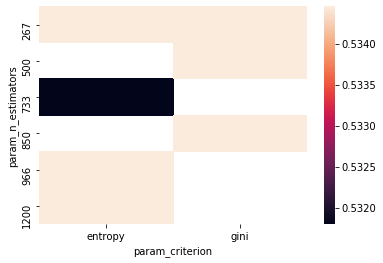

In [20]:
import seaborn as sns

table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_n_estimators', 
                       columns='param_criterion')
     
sns.heatmap(table)

In [21]:
pred=model.predict(xvalid_count)

In [23]:
f1_score(pred, valid_y,average='weighted') * 100

67.16826265389876

In [31]:
print(classification_report(valid_y, model.predict(xvalid_count), digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       246
           1     0.5057    1.0000    0.6717       491
           2     0.0000    0.0000    0.0000       234

    accuracy                         0.5057       971
   macro avg     0.1686    0.3333    0.2239       971
weighted avg     0.2557    0.5057    0.3396       971



C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(pred,valid_y) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(pred,valid_y,average='weighted') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(pred,valid_y))

Accuracy: 50.57%

F1 Score: 67.17

COnfusion Matrix:
 [[  0   0   0]
 [246 491 234]
 [  0   0   0]]


In [74]:
# Naive Bayes on Count Vectors
accuracy = train_models(naive_bayes.MultinomialNB(), xtrain_count, train_y, xvalid_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_models(naive_bayes.MultinomialNB(), xtrain_tfidf, train_y, xvalid_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_models(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

# Naive Bayes on Character Level TF IDF Vectors
accuracy = train_models(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("NB, CharLevel Vectors: ",accuracy)

NB, Count Vectors:  61.26796478275662
NB, WordLevel TF-IDF:  67.14589164078278
NB, N-Gram Vectors:  65.87204511748638
NB, CharLevel Vectors:  67.16826265389876


In [75]:
# Linear Classifier on Count Vectors
accuracy = train_models(linear_model.LogisticRegression(), xtrain_count, train_y, xvalid_count)
print("LR, Count Vectors: ", accuracy)

# Linear Classifier on Word Level TF IDF Vectors
accuracy = train_models(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("LR, WordLevel TF-IDF: ", accuracy)

# Linear Classifier on Ngram Level TF IDF Vectors
accuracy = train_models(linear_model.LogisticRegression(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("LR, N-Gram Vectors: ", accuracy)

# Linear Classifier on Character Level TF IDF Vectors
accuracy = train_models(linear_model.LogisticRegression(), xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars)
print("LR, CharLevel Vectors: ", accuracy)

C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LR, Count Vectors:  45.274529669617245
LR, WordLevel TF-IDF:  61.152896432797576
LR, N-Gram Vectors:  61.29481961549862
LR, CharLevel Vectors:  63.88332450152644


In [76]:
# SVM on Ngram Level TF IDF Vectors
accuracy = train_models(svm.SVC(), xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", accuracy)

SVM, N-Gram Vectors:  66.12837700302121


In [79]:
# RF on Count Vectors
accuracy = train_models(ensemble.RandomForestClassifier(), xtrain_count, train_y, xvalid_count)
print("RF, Count Vectors: ", accuracy)

# RF on Word Level TF IDF Vectors
accuracy = train_models(ensemble.RandomForestClassifier(), xtrain_tfidf, train_y, xvalid_tfidf)
print ("RF, WordLevel TF-IDF: ", accuracy)

RF, Count Vectors:  66.2489563832848
RF, WordLevel TF-IDF:  65.17927722687078


In [82]:
# Extereme Gradient Boosting on Count Vectors
accuracy = train_models(xgboost.XGBClassifier(), xtrain_count.tocsc(), train_y, xvalid_count.tocsc())
print("Xgb, Count Vectors: ", accuracy)

# Extereme Gradient Boosting on Word Level TF IDF Vectors
accuracy = train_models(xgboost.XGBClassifier(), xtrain_tfidf.tocsc(), train_y, xvalid_tfidf.tocsc())
print ("Xgb, WordLevel TF-IDF: ", accuracy)

# Extereme Gradient Boosting on Character Level TF IDF Vectors
accuracy = train_models(xgboost.XGBClassifier(), xtrain_tfidf_ngram_chars.tocsc(), train_y, xvalid_tfidf_ngram_chars.tocsc())
print ("Xgb, CharLevel Vectors: ", accuracy)

Xgb, Count Vectors:  64.29899633222536
Xgb, WordLevel TF-IDF:  63.92860551951701
Xgb, CharLevel Vectors:  63.62441713365571


In [72]:
print('Accuracy',acc)
print('score',score)

Accuracy 0.49948506694129763
score 65.87204511748638


In [50]:
prediction_fin = classifier_nb.predict(zvalid_tfidf_ngram_chars)

In [53]:
print(list(prediction_fin))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [54]:
pred=encoder.inverse_transform(prediction_fin)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [60]:
test['sentiment_class']=pred

In [61]:
test.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood,0
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii,0
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg,0
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters,0
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg,0


In [62]:
final=pd.DataFrame(test[['id','sentiment_class']])
final.head()

,id,sentiment_class
0,1.246628e+18,0
1,1.245898e+18,0
2,1.244717e+18,0
3,1.245730e+18,0
4,1.244636e+18,0


In [63]:
final.to_csv('submission_file.csv',index=False,sep=',')
# dt.to_csv('file_name.csv',sep='\t')

XGBoost classifier
XGBoost is a version of gradient boosted decision tree classifier. In boosting, the trees are built sequentially such that each subsequent tree aims to reduce the errors of the previous tree. These subsequent trees are called base or weak learners. Each of these weak learners contributes some vital information for prediction, enabling the boosting technique to produce a strong learner by effectively combining these weak learners. The power of XGBoost lies in its scalability, which drives fast learning through parallel and distributed computing and offers efficient memory usage.

We will not do a very detailed hyperparameter optimization becuase it is very time consuming, but rather predifine certain input arguments that control the performance of the classifier and use one argument to otpimize. subsample controls the ratio of the randomly selected training samples before growing the tree. It ranges between 0 and 1. Higher values tend to cause overfitting. colsample_bytree denotes the fraction of columns to be randomly sampled for each tree. n_estimators controls the number of trees to be constructed during the classification process. We will optimize that parameter.

In [14]:
X = train.original_text
y = train.sentiment_class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [15]:

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

# %%time

y_pred = nb.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred,average='weighted'))

accuracy 0.505664263645726


C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       246
           0       0.51      1.00      0.67       491
           1       0.00      0.00      0.00       234

    accuracy                           0.51       971
   macro avg       0.17      0.33      0.22       971
weighted avg       0.26      0.51      0.34       971

0.3396459007524644


In [16]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

# %%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % metrics.accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5036045314109165
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       246
           0       0.50      1.00      0.67       491
           1       0.00      0.00      0.00       234

    accuracy                           0.50       971
   macro avg       0.17      0.33      0.22       971
weighted avg       0.26      0.50      0.34       971



In [25]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [21]:
df_x = train['original_text']
df_y = train['sentiment_class']
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.25)

In [22]:
import nltk
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [23]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))


In [26]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df_x).transform(df_x)

100%|██████████| 3235/3235 [00:00<00:00, 403994.92it/s]


In [27]:
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())

100%|██████████| 2588/2588 [00:00<00:00, 251432.84it/s]


Accuracy for XGBoost Classifier :  0.5180834621329211


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [29]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df_x).transform(df_x)

In [30]:
tfidf_vectors.shape

(3235, 12442)

In [32]:
from sklearn.linear_model import LogisticRegression
pl_log_reg_tf_idf = Pipeline(steps=[('tfidf',Text2TfIdfTransformer()),
                             ('log_reg', LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100))])
scores = cross_val_score(pl_log_reg_tf_idf, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for Tf-Idf & Logistic Regression: ', scores.mean())

C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\kjk\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy for Tf-Idf & Logistic Regression:  0.5137557959814527


In [33]:
from sklearn.ensemble import RandomForestClassifier

pl_random_forest = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                                   ('random_forest', RandomForestClassifier())])
scores = cross_val_score(pl_random_forest, df_x, df_y, cv=5,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

100%|██████████| 2588/2588 [00:00<00:00, 647124.05it/s]


Accuracy for RandomForest :  0.5180834621329212


In [34]:
import xgboost as xgb

pl_xgb = Pipeline(steps=[('doc2vec',Doc2VecTransformer()),
                         ('xgboost', xgb.XGBClassifier(objective='multi:softmax'))])
scores = cross_val_score(pl_xgb, df_x, df_y, cv=5)
print('Accuracy for XGBoost Classifier : ', scores.mean())


100%|██████████| 2588/2588 [00:00<00:00, 646661.43it/s]


Accuracy for XGBoost Classifier :  0.5069551777434311
